In [34]:
#1) Import libraries
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import Environments
from collections import OrderedDict
import pandas as pd
import time
# I use the work of Moritz Taylor to help me build this algorithm. Link: https://github.com/MoritzTaylor/ddpg-pytorch

In [35]:
#2) Set up exploration class and replay buffer.

class ActionNoise:
    """
        Class: Add noise to our action for exploration
        :param mean: mean of the gaussian noise
        :param std_dev: standard deviation of the gaussian noise
        :param comp_time: computing time
    """
    def __init__(self, mean, std_deviation, comp_time):
        self.mean = mean
        self.std_dev = std_deviation
        self.comp_time = comp_time
        self.ratio_std=1.0
    
    def __call__(self,size):
        """
        Getting noise
        :param size: size of the Tensor with noise values
        :return: Tensor with gaussian noise
        """
        std=max(self.ratio_std*self.std_dev,0.1)
        return torch.normal(torch.tensor(self.mean).repeat(size),torch.tensor(std).repeat(size))
    
    
    def change_std(self, current_time):
        """
        Changing the standard deviation to reduce exploration over time
        """   
        self.ratio_std=(self.comp_time-current_time)/self.comp_time

Transition = namedtuple('Transition',('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory(object):
    """
        Class: Replay Buffer (RB)
        :param capacity: capacity in memory
    """
    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    
    def push(self, *args):
        """
        Save a transition object in RB
        :param args: elements in Transition object
        """
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        """
        Get a sample from RB
        :param batch_size: number of objets in sample
        :return: sample of Transition object
        """
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        """
        Get number of saved objets
        :return: number of saved objets
        """
        return len(self.memory)



In [36]:
#3) Set up Neural Network functions and classes

def soft_update(target, source, tau):
    """
        Soft update for a neural network (NN) from an other NN
        :param source: NN used for weights copy
        :param tau: ratio parameter for copy
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    """
        Hard update for a neural network (NN) from an other NN
        :param source: NN used for weights copy ( like soft update with tau=1.0)
    """ 
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

class DDPG_actor(nn.Module):
    """
        Class: actor NN
        :param np_inputs: size input of the NN (size state)
        :param nb_outputs: size output of the NN (size action)
        :param model: name of the NN
    """   
    def __init__(self, np_inputs, nb_outputs, model):
        super(DDPG_actor, self).__init__()  
        self.layer1=nn.Linear(np_inputs, 64)
        self.layer2=nn.Linear(64, 64)
        self.layer3=nn.Linear(64, nb_outputs)
        #self.Tanh=nn.Tanh()
        torch.nn.init.uniform_(self.layer3.weight,-0.003, 0.003)
        self.name=model
    
      
    def forward(self, input1):
        """
        Forward NN : compute the NN with respect the current state
        :param input1: state
        :return: output of the NN, action
        """ 
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        output=F.relu(self.layer1(input1))
        output=F.relu(self.layer2(output))
        output=torch.tanh(self.layer3(output))
        return output
    
class DDPG_critic(nn.Module):
    """
        Class : critic NN
        :param nb_input1: size input state part of the NN (size state)
        :param nb_input2: size input actor part of the NN (size action)
        :param nb_outputs: size output of the NN (size Q_value =1)
        :param model: name of the NN
    """
    def __init__(self, nb_input1, nb_input2, nb_outputs, model):
        
        super(DDPG_critic, self).__init__()  
        self.state_net1=nn.Linear(nb_input1, 48)
        self.state_net2=nn.Linear(48, 48)
        self.action_net1=nn.Linear(nb_input2, 48)
        self.merge_net1=nn.Linear(96, 48)
        self.merge_net2=nn.Linear(48, nb_outputs)
        torch.nn.init.uniform_(self.merge_net2.weight,-0.003, 0.003)
        self.name=model
        
      
    def forward(self, input1, input2):
        """
        Forward NN : compute the NN with respect the current state and action
        :param input1: state
        :param input2: action
        :return: output of the NN, Q_value
        """ 
        if isinstance(input1, np.ndarray):
            input1 = torch.tensor(input1, dtype=torch.float)
        if isinstance(input2, np.ndarray):
            input2 = torch.tensor(input2, dtype=torch.float)
            
        output1=F.relu(self.state_net1(input1))
        output1=F.relu(self.state_net2(output1))
        output2=F.relu(self.action_net1(input2))
        output3=torch.cat((output1,output2),dim=1)
        output_final=F.relu(self.merge_net1(output3))
        output_final=self.merge_net2(output_final)
        return output_final

In [38]:
#4) Rollout on the environment:
class Env_rollout:
    """ 
        Class : iterate on the environment
        :param env: our environment
        :param max_steps: max steps per episode
    """
    def __init__(self, env, max_steps):
        self.env = env
        self.max_steps = max_steps
        self.prev_state = env.reset()
    
    
    def select_action(self, actor_net, state):
        """ 
        Get a new action
        :param actor_net: current policy (actor NN)
        :param state: current state
        :return: action NN, action NN clipped
        """
        actor_net.eval()
        action=torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(state), dim=0)))
        if(action.dim()==0):
            action=torch.unsqueeze(action,dim=0)
        legal_action=torch.clamp(action, min=-1e0, max=1e0)
        return action, legal_action
    
    """ 
        Get a new action
        :param actor_net: current policy (actor NN)
        :param state: current state
        :return: action NN, action NN clipped
    """
    def iterations(self,actor_net, nbr_episodes):
        """
        Iterate on the environment.
        :param actor_net: current policy (actor NN)
        :param nbr_episodes: episode number
        :return: Tensors; state batch, action batch, reward batch
        """
        batch_obs=[]
        batch_acts=[]
        batch_rews=[]
        for ep in range(nbr_episodes):
            prev_state = env.reset()
            for step_ep in range(self.max_steps): 
                with torch.no_grad():
                    action, legal_action = self.select_action(actor_net, prev_state)
                    state, reward, done, _ = self.env.step(legal_action.detach().numpy())
                    batch_obs.append(prev_state)
                    batch_acts.append(legal_action.detach().numpy())
                    batch_rews.append(reward)
                    prev_state = state
                if done:
                    break
        return torch.tensor(batch_obs, dtype=torch.float), torch.tensor(batch_acts, dtype=torch.float), torch.tensor(batch_rews, dtype=torch.float)



In [39]:
#5) Algorithm DDPG:
class Algo_DDPG():
    """ 
        PPO algorithm : training and testing
        :param policy_class_a: policy (actor model)
        :param policy_class_c: policy (critic model)
        :param env: environment
        :param hyperparameters: other hyperparameters
    """
    def __init__(self, policy_class_a, policy_class_c, env, **hyperparameters):
        
        self._init_hyperparameters(hyperparameters)
        self.actor_net = policy_class_a(num_states, num_actions, "online")
        self.critic_net = policy_class_c(num_states, num_actions, 1, "online")
        self.target_actor_net = policy_class_a(num_states, num_actions, "target")
        self.target_critic_net = policy_class_c(num_states, num_actions, 1, "target")
        hard_update(self.target_critic_net,self.critic_net)
        hard_update(self.target_actor_net,self.actor_net)
        self.optimizer_critic = optim.Adam(self.critic_net.parameters(), self.critic_lr)#,weight_decay=0.01)
        self.optimizer_actor = optim.Adam(self.actor_net.parameters(), self.actor_lr)
        self.rollout = Env_rollout(env, self.max_steps)
    
    def evaluate(self, nbr_episodes, selection):
        """
        Testing
        :param nbr_episodes: episode number 
        :param selection: target or current policy NN
        :return: state batch, action batch, and reward batch
        """
        if(selection=="target"):
            state_batch, action_batch, rewards_batch = self.rollout.iterations(self.target_actor_net, nbr_episodes)
        else:
            state_batch, action_batch, rewards_batch = self.rollout.iterations(self.actor_net, nbr_episodes)
        return state_batch, action_batch, rewards_batch
    
    def optimize_model(self):
        """
        Model Optimization
        :return: batch reward
        """
        if len(self.memory) < self.batch_size:
            return
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        criterion=nn.MSELoss(reduction='mean')
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        next_state_batch = torch.cat(batch.next_state)
        done_batch = torch.cat(batch.done)
        
        #Critic optimization
        self.optimizer_critic.zero_grad()
        target_actor_batch = self.target_actor_net.forward(next_state_batch)
        target_critic_batch = self.target_critic_net.forward(next_state_batch,target_actor_batch.detach())
        critic_action_batch = self.critic_net.forward(state_batch,action_batch)
        expected_state_action_values = (torch.mul(target_critic_batch, 1 - done_batch) * self.gamma) + reward_batch
        critic_loss = criterion(expected_state_action_values.detach(),critic_action_batch)
        critic_loss.backward()
        self.optimizer_critic.step()

        #Actor optimization
        #see if i can optimize only some times
        actor_batch = self.actor_net.forward(state_batch)
        critic_actor_batch = self.critic_net.forward(state_batch,actor_batch)
        actor_loss = - critic_actor_batch.mean()
        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()
        return reward_batch
    
    def select_action(self, actor_net, state, noise):
        """ 
        Get a new action
        :param actor_net: current policy (actor NN)
        :param state: current state
        :param noise: noise object
        :return: action NN, action NN clipped
        """
        actor_net.eval()
        action=torch.squeeze(actor_net(torch.unsqueeze(torch.tensor(state), dim=0)))
        actor_net.train()
        if(action.dim()==0):
            action=torch.unsqueeze(action,dim=0)
        if(noise is not None):
            action=action+noise(1)
        legal_action=torch.clamp(action, min=-1e0, max=1e0)
        return action, legal_action
    
    def train(self, comp_time):
        """ 
        Training
        :param comp_time: computing time
        """
        self.noise = ActionNoise(self.mean_dev, self.std_dev, comp_time)
        if(self.total_time==0.0):
            for i in range(10):
                prev_state = env.reset()
                #episodic_reward = torch.tensor([0.0], device=device).float()
                for step_ep in range(self.max_steps):
                    action, legal_action = self.select_action(self.actor_net, prev_state, self.noise)
                    state, reward, done, _ = env.step(legal_action.detach().numpy())
                    episodic_reward = torch.tensor([reward], device=device)#+episodic_reward
                    done_t = torch.tensor([int(done)])
                    self.memory.push(torch.unsqueeze(torch.tensor(prev_state), dim=0),
                                     torch.unsqueeze(action.detach(), dim=0).float(),
                                     torch.unsqueeze(episodic_reward, dim=0).float(),
                                     torch.unsqueeze(torch.tensor(state), dim=0).float(),
                                     torch.unsqueeze(done_t, dim=0))
                    if done:
                        break
        start = time.process_time()
        while time.process_time()-start<comp_time:
            prev_state = env.reset()
            #episodic_reward = torch.tensor([0.0], device=device).float()
            for step_ep in range(self.max_steps):
                action, legal_action = self.select_action(self.actor_net, prev_state, self.noise)
                state, reward, done, _ = env.step(legal_action.detach().numpy())
                episodic_reward = torch.tensor([reward])#+episodic_reward
                done_t = torch.tensor([int(done)])
                self.memory.push(torch.unsqueeze(torch.tensor(prev_state), dim=0),
                                 torch.unsqueeze(action.detach(), dim=0).float(),
                                 torch.unsqueeze(episodic_reward, dim=0).float(),
                                 torch.unsqueeze(torch.tensor(state), dim=0).float(),
                                 torch.unsqueeze(done_t, dim=0)
                                )
                prev_state = state
                self.nb_loop= self.nb_loop +1
                self.noise.change_std(time.process_time()-start)
                if (self.nb_loop%10==0): #policy delay=2
                    batch_rew2=self.optimize_model()
                    soft_update(self.target_critic_net,self.critic_net,self.tau)
                    soft_update(self.target_actor_net,self.actor_net,self.tau)
                    #if(batch_rew2 != None):
                    #    self.ep_reward_list.append(batch_rew2.mean().detach().numpy())
                if (self.nb_loop%2000==0):
                    state_batch, action_batch, rewards_batch = self.rollout.iterations(self.target_actor_net, 30)
                    self.ep_reward_list.append(rewards_batch.mean().numpy())
                    avg_reward = np.mean(self.ep_reward_list[-10:])
                    print("Steps * {} * Avg Reward is ==> {} and Time {}".format(self.nb_loop, avg_reward,time.process_time()-start))
                    #hard_update(self.critic_net,self.target_critic_net)
                    #hard_update(self.actor_net,self.target_actor_net)
                if done:
                    break
        self.total_time=time.process_time()-start
        path='load_model/parameters/ddpg-{num_algo:02d}-{name}-time-{time:06d}.npy'
        with open(path.format(num_algo=self.num_algo,time=int(self.total_time),name="reward"), 'wb') as f:
            np.save(f, np.array(self.ep_reward_list))
        print("Complete")
        return self.nb_loop
        
    def _init_hyperparameters(self, hyperparameters):
        """
        Initialize hyperparameters. 
        :param hyperparameters: hyperparameter list
        """
        self.num_algo = 1
        self.batch_size = 100
        self.memory = ReplayMemory(1000000)
        self.tau = 0.005
        self.gamma = 0.99
        self.mean_dev = 0.0
        self.std_dev = 0.5
        self.max_steps = 90
        self.total_time = 0.0
        self.nb_loop = 0
        self.critic_lr = 3e-3
        self.actor_lr = 3e-4
        self.ep_reward_list=[]
        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val)) #juste trop fort
            
    def loading(self, num_algo, total_time):
        """
        Loading NN weights 
        :param num_algo: algorithm number
        :param total_loop: step number
        """
        self.num_algo = num_algo
        self.total_time = total_time
        checkpoint_path1 = "load_model/weights/ddpg-{num_algo:02d}-actor-time-{time:06d}.pth"
        self.actor_net.load_state_dict(torch.load(checkpoint_path1.format(epoch=int(self.total_time), num_algo=self.num_algo)))
        checkpoint_path2 = "load_model/weights/ddpg-{num_algo:02d}-critic-time-{time:06d}.pth"
        self.critic_net.load_state_dict(torch.load(checkpoint_path2.format(time=int(self.total_time), num_algo=self.num_algo)))
        hard_update(self.target_critic_net,self.critic_net)
        hard_update(self.target_actor_net,self.actor_net)
        
    def saving(self):
        """
        Saving NN weights 
        """
        checkpoint_path = "load_model/weights/ddpg-{num_algo:02d}-actor-time-{time:06d}.pth"
        torch.save(self.target_actor_net.state_dict(),checkpoint_path.format(time=int(self.total_time), num_algo=self.num_algo))
        checkpoint_path = "load_model/weights/ddpg-{num_algo:02d}-critic-time-{time:06d}.pth"
        torch.save(self.target_critic_net.state_dict(),checkpoint_path.format(time=int(self.total_time), num_algo=self.num_algo))
        


In [40]:
#6) Computing part:
# Import environment
problem = "Crosswalk_comparison-v0"
u_b = [2.0, 11.0, -12.5, 1.1, -1.0]
l_b = [-4.0, 9.0, -32.5, 0.9, -2.0]

env = gym.make(problem,dt=0.3,Vm=2.5,tau=1.0,lower_bounds=l_b, upper_bounds=u_b,simulation="sin")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the algorithm
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
num_algo=1

algo=Algo_DDPG(DDPG_actor, DDPG_critic, env, num_algo= num_algo, num_states=num_states, num_actions=num_actions)
#algo.loading(1,3600)

In [41]:
#Training
import time
nb_step=algo.train(3600)
algo.saving()
print("Steps: "+str(nb_step))

Accident!
Accident!
Accident!
Accident!
Steps * 2000 * Avg Reward is ==> -88.10540008544922 and Time 6.90625
Accident!
Steps * 4000 * Avg Reward is ==> -122.75537109375 and Time 13.796875
Accident!
Steps * 6000 * Avg Reward is ==> -124.1499252319336 and Time 20.578125
Accident!
Steps * 8000 * Avg Reward is ==> -107.7651596069336 and Time 27.234375
Accident!
Steps * 10000 * Avg Reward is ==> -88.69247436523438 and Time 34.34375
Accident!
Accident!
Accident!
Accident!
Steps * 12000 * Avg Reward is ==> -74.83028411865234 and Time 41.328125
Accident!
Steps * 14000 * Avg Reward is ==> -65.05681610107422 and Time 48.265625
Accident!
Accident!
Accident!
Steps * 16000 * Avg Reward is ==> -58.00092315673828 and Time 54.875
Accident!
Accident!
Steps * 18000 * Avg Reward is ==> -52.339393615722656 and Time 61.875
Accident!
Steps * 20000 * Avg Reward is ==> -47.7342529296875 and Time 68.828125
Accident!
Steps * 22000 * Avg Reward is ==> -39.540374755859375 and Time 75.75
Steps * 24000 * Avg Reward

Accident!
Steps * 176000 * Avg Reward is ==> -2.647214651107788 and Time 752.796875
Steps * 178000 * Avg Reward is ==> -2.6160292625427246 and Time 762.515625
Steps * 180000 * Avg Reward is ==> -2.641540765762329 and Time 772.140625
Steps * 182000 * Avg Reward is ==> -2.6325156688690186 and Time 781.890625
Steps * 184000 * Avg Reward is ==> -2.598240613937378 and Time 791.609375
Steps * 186000 * Avg Reward is ==> -2.606419324874878 and Time 801.3125
Steps * 188000 * Avg Reward is ==> -2.587827444076538 and Time 810.984375
Steps * 190000 * Avg Reward is ==> -2.5461223125457764 and Time 820.71875
Steps * 192000 * Avg Reward is ==> -2.484205722808838 and Time 830.109375
Steps * 194000 * Avg Reward is ==> -2.4738168716430664 and Time 839.890625
Steps * 196000 * Avg Reward is ==> -2.3303825855255127 and Time 849.484375
Steps * 198000 * Avg Reward is ==> -2.3062515258789062 and Time 859.203125
Steps * 200000 * Avg Reward is ==> -2.2666070461273193 and Time 869.0
Steps * 202000 * Avg Reward i

Steps * 380000 * Avg Reward is ==> -2.842322826385498 and Time 1870.328125
Steps * 382000 * Avg Reward is ==> -2.7676644325256348 and Time 1883.109375
Steps * 384000 * Avg Reward is ==> -2.6846537590026855 and Time 1896.0625
Accident!
Accident!
Steps * 386000 * Avg Reward is ==> -2.6909635066986084 and Time 1908.84375
Steps * 388000 * Avg Reward is ==> -2.675668239593506 and Time 1921.84375
Accident!
Steps * 390000 * Avg Reward is ==> -2.6335740089416504 and Time 1934.875
Steps * 392000 * Avg Reward is ==> -2.6379189491271973 and Time 1947.78125
Steps * 394000 * Avg Reward is ==> -2.6175684928894043 and Time 1960.859375
Steps * 396000 * Avg Reward is ==> -2.474883556365967 and Time 1975.84375
Steps * 398000 * Avg Reward is ==> -2.4517970085144043 and Time 1988.9375
Steps * 400000 * Avg Reward is ==> -2.419965982437134 and Time 2002.140625
Steps * 402000 * Avg Reward is ==> -2.484616756439209 and Time 2015.359375
Steps * 404000 * Avg Reward is ==> -2.500253677368164 and Time 2028.609375

Steps * 584000 * Avg Reward is ==> -4.031192302703857 and Time 3249.90625
Steps * 586000 * Avg Reward is ==> -3.9334378242492676 and Time 3263.84375
Steps * 588000 * Avg Reward is ==> -3.8855361938476562 and Time 3277.921875
Steps * 590000 * Avg Reward is ==> -3.757880449295044 and Time 3291.9375
Steps * 592000 * Avg Reward is ==> -3.6301956176757812 and Time 3305.953125
Accident!
Steps * 594000 * Avg Reward is ==> -3.729647397994995 and Time 3320.078125
Steps * 596000 * Avg Reward is ==> -3.6718459129333496 and Time 3333.921875
Steps * 598000 * Avg Reward is ==> -3.6868743896484375 and Time 3347.921875
Accident!
Steps * 600000 * Avg Reward is ==> -3.6069464683532715 and Time 3362.046875
Accident!
Accident!
Steps * 602000 * Avg Reward is ==> -3.541774272918701 and Time 3376.25
Steps * 604000 * Avg Reward is ==> -3.4778876304626465 and Time 3390.359375
Steps * 606000 * Avg Reward is ==> -3.4353110790252686 and Time 3406.484375
Accident!
Steps * 608000 * Avg Reward is ==> -3.347902297973

In [15]:
#Stock an evaluation sample
states, actions, rewards = algo.evaluate(2000, "target")
ep_action=states[:,0]
ep_speed_car=states[:,1]
ep_pos_car=states[:,2]
ep_speed_ped=states[:,3]
ep_pos_ped=states[:,4]
ep_time=states[:,9]
ep_reward=rewards
t=0

In [16]:
#Show general information about the final algorithm performance: average speed, CO2 emission, end-time

LDV = pd.read_csv('LDV.csv', sep=';',names=["sp","acc","step","em_name","em_val"])
LDV.pop('step')
m = LDV == 0.0
LDV['acc'] = LDV['acc'].replace(1.27676e-15,0.0)
LDV['acc'] = LDV['acc'].astype(float)
LDV_array = np.array(LDV.values)

def info_co2(states,LDV):
    """
        Evaluate the CO2 emission per episode 
        :param states: state list
        :param LDV: CO2 emission chart
    """
    t=0
    total_emission=[]
    while t+1<len(ep_time):
        t_init=t
        emission_val=[]
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            acc=math.trunc(((states[t,0].item()//0.2)*0.2)*10.)/10.
            speed=math.trunc(((states[t,1].item()//0.5)*0.5)*10.)/10.
            cond=(LDV.sp==speed)&(LDV.acc==acc)&(LDV.em_name=="CO2")
            res=LDV[cond]['em_val'].item() *0.3
            emission_val.append(res)
            t+=1
        total_emission.append(torch.sum(torch.tensor(emission_val),dim=0))
        t+=1
    torch_total_emission=torch.tensor(total_emission)
    total_emission_mean=torch.mean(torch_total_emission)
    total_emission_std=torch.std(torch_total_emission)
    print("\nThe average CO2 emission is {:.2f}mg and its standard deviation is {:.2f} mg".format(total_emission_mean.item(),total_emission_std.item()))
    
def get_average(states,LDV):
    """
        Evaluate the episode with general information (average speed, CO2 emission, end-time)
        :param states: state list
        :param LDV: CO2 emission chart
    """
    ep_time=states[:,9]
    mean_speed=torch.mean(states[:,1])
    sqrt_speed=torch.std(states[:,1])
    print("The average car speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed.item(),sqrt_speed.item()))
    mean_acc=torch.mean(states[:,0])
    sqrt_acc=torch.std(states[:,0])
    print("\nThe average car acceleration is {:.2f} m/s2 and its standard deviation is {:.2f} m/s2".format(mean_acc.item(),sqrt_acc.item()))
    mean_speed_p=torch.mean(states[:,3])
    sqrt_speed_p=torch.std(states[:,3])
    print("\nThe average pedestrian speed is {:.2f} m/s and its standard deviation is {:.2f} m/s".format(mean_speed_p.item(),sqrt_speed_p.item()))    
    mean_reward=torch.mean(ep_reward)
    std_reward=torch.std(ep_reward)
    print("\nThe average reward is {:.2f} and its standard deviation is {:.2f}".format(mean_reward.item(),std_reward.item()))
    info_co2(states,LDV) #CO2 info
    temps=[]
    t=0
    while t+1<len(ep_time):
        temps_i=np.array([0.,0.]) #respectively: end-time car/pedestrian
        t_init=t
        while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
            if(states[t,2]<0.0 and states[t+1,2]>=0.0):
                temps_i[0]=(t-t_init)*0.3
            if(states[t,4]<5.0 and states[t+1,4]>=5.0):
                temps_i[1]=(t-t_init)*0.3
            t+=1
        if(temps_i[1]==0.0):
            temps_i[1]=(t-t_init)*0.3
        temps.append([(t-t_init)*0.3,temps_i[0],temps_i[1]])
        t+=1
    total_temps=torch.tensor([temps]).reshape((-1,3))
    total_temps_mean=torch.mean(total_temps,dim=0)
    print("\n Average End-times:")
    print("Total: {:.2f} s".format(total_temps_mean[0].item()))
    print("Car: {:.2f} s".format(total_temps_mean[1].item()))
    print("Pedestrian: {:.2f} s".format(total_temps_mean[2].item()))
get_average(states,LDV)

The average car speed is 6.88 m/s and its standard deviation is 3.31 m/s

The average car acceleration is -0.07 m/s2 and its standard deviation is 1.50 m/s2

The average pedestrian speed is 0.99 m/s2 and its standard deviation is 0.38 m/s2

The average reward is -1.17 and its standard deviation is 1.97

The average CO2 emission is 19040.42mg and its standard deviation is 8965.61 mg

 Average End-times:
Total: 9.86 s
Car: 4.76 s
Pedestrian: 6.62 s


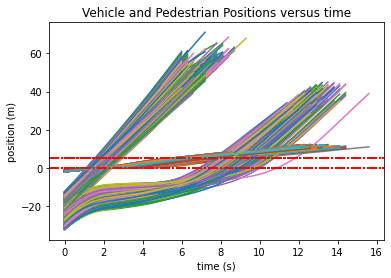

In [17]:

t=0
plt.title("Vehicle and Pedestrian Positions versus time")
plt.xlabel("time (s)")
plt.ylabel("position (m)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    plt.plot(ep_time[t_init:t],ep_pos_car[t_init:t])
    plt.plot(ep_time[t_init:t],ep_pos_ped[t_init:t])
    plt.axhline(y=5, color='r', linestyle='-.')
    plt.axhline(y=0, color='r', linestyle='-.')
    t+=1
_=plt.axhline(y=5, color='r', linestyle='-.')
_=plt.axhline(y=0, color='r', linestyle='-.')

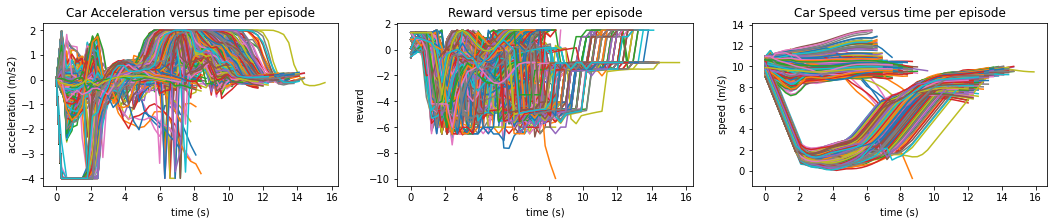

In [18]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18, 3))

t=0
ax1.set_title("Car Acceleration versus time per episode")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("acceleration (m/s2)")

ax2.set_title("Reward versus time per episode")
ax2.set_xlabel("time (s)")
ax2.set_ylabel("reward")

ax3.set_title("Car Speed versus time per episode")
ax3.set_xlabel("time (s)")
ax3.set_ylabel("speed (m/s)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    ax1.plot(ep_time[t_init:t],ep_action[t_init:t])
    ax2.plot(ep_time[t_init:t],ep_reward[t_init:t])
    ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1])
    t+=1


In [19]:
#Seperate the episodes and the different behaviors
t=0
cross_speed=[]
wait_speed=[]
cross_acc=[]
wait_acc=[]
size_wait=20
size_cross=30

while t+1<len(ep_time):
    t_init=t
    choice=False
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        choice=choice+(ep_speed_car[t]<2.0)
        t+=1
    if(choice):
        cross_speed.append(np.array(ep_speed_car[t_init:t_init+size_cross]))
        cross_acc.append(np.array(states[t_init:t_init+size_cross,0]))
    else:
        wait_speed.append(np.array(ep_speed_car[t_init:t_init+size_wait]))
        wait_acc.append(np.array(states[t_init:t_init+size_wait,0]))
    t+=1
    
cross_speed=np.array(cross_speed)
wait_speed=np.array(wait_speed)
cross_acc=np.array(cross_acc)
wait_acc=np.array(wait_acc)

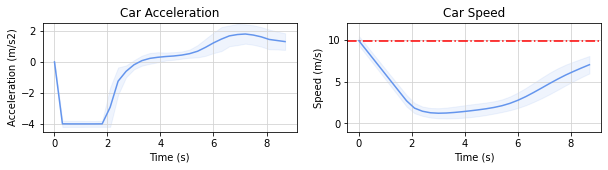

In [20]:
x1=[0.3*i for i in range(size_cross)]
mean_speed=np.mean(cross_speed,axis=0)
std_speed=np.std(cross_speed,axis=0)
mean_acc=np.mean(cross_acc,axis=0)
std_acc=np.std(cross_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x1,mean_acc,color='cornflowerblue')
ax1.fill_between(x1, (mean_acc-std_acc), (mean_acc+std_acc), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed[0], color='r', linestyle='-.')
ax2.plot(x1,mean_speed,color='cornflowerblue')
ax2.fill_between(x1, (mean_speed-std_speed), (mean_speed+std_speed), color='cornflowerblue', alpha=0.1)

ax2.grid(True,color='lightgrey')


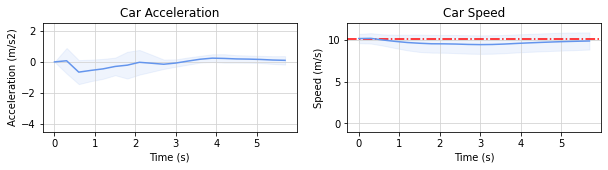

In [21]:
x2=[0.3*i for i in range(size_wait)]

mean_speed2=np.mean(wait_speed,axis=0)
std_speed2=np.std(wait_speed,axis=0)
mean_acc2=np.mean(wait_acc,axis=0)
std_acc2=np.std(wait_acc,axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 2))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.set_ylim(-4.5,2.5)
ax1.plot(x2,mean_acc2,color='cornflowerblue')
ax1.fill_between(x2, (mean_acc2-std_acc2), (mean_acc2+std_acc2), color='cornflowerblue', alpha=0.1)
ax1.grid(True,color='lightgrey')

ax2.set_title('Car Speed')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Speed (m/s)")
ax2.set_ylim(-1.0,12.0)
ax2.axhline(y=mean_speed2[0], color='r', linestyle='-.')
ax2.plot(x2,mean_speed2,color='cornflowerblue')
ax2.fill_between(x2, (mean_speed2-std_speed2), (mean_speed2+std_speed2), color='cornflowerblue', alpha=0.1)
ax2.grid(True,color='lightgrey')


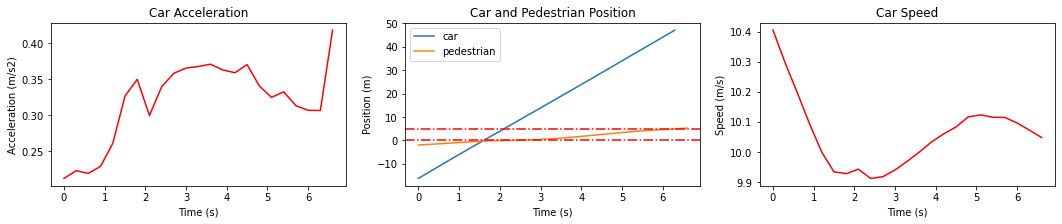

In [22]:
#Showing Vehicle Acceleration Diagram, Vehicle Speed Diagram, Vehicle and Pedestrian Position Diagram
#All three over time in an episode

#t=0
if (t+1>=len(ep_time)):
    t=0
t_init=t
while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
    t+=1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(18, 3))
ax1.set_title('Car Acceleration')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Acceleration (m/s2)")
ax1.plot(ep_time[t_init:t+1],actions[t_init:t+1,0],color='r')

ax2.set_title('Car and Pedestrian Position')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Position (m)")
ax2.plot(ep_time[t_init:t],ep_pos_car[t_init:t],label='car')
ax2.plot(ep_time[t_init:t+1],ep_pos_ped[t_init:t+1],label='pedestrian')
ax2.axhline(y=5, color='r', linestyle='-.')
ax2.axhline(y=0, color='r', linestyle='-.')
ax2.legend()

ax3.set_title('Car Speed')
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Speed (m/s)")
ax3.plot(ep_time[t_init:t+1],ep_speed_car[t_init:t+1],color='r')

t+=1